In [1]:
import zipfile
import pandas as pd

# Відкриття головного архіву
with zipfile.ZipFile('toxic_comment_classification.zip', 'r') as z:
    # Виведення списку файлів в архіві
    z.printdir()

    # Спочатку витягаємо вкладені архіви
    z.extractall('extracted_archives')

# Тепер працюємо з витягнутими архівами
nested_archives = ['extracted_archives/train.csv.zip',
                   'extracted_archives/test.csv.zip',
                   'extracted_archives/test_labels.csv.zip',
                   'extracted_archives/sample_submission.csv.zip']

# Функція для розпакування і завантаження CSV
def load_csv_from_zip(zip_path, csv_name):
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(csv_name) as f:
            return pd.read_csv(f)

# Завантаження CSV-файлів
train_data = load_csv_from_zip(nested_archives[0], 'train.csv')
test_data = load_csv_from_zip(nested_archives[1], 'test.csv')
test_labels = load_csv_from_zip(nested_archives[2], 'test_labels.csv')
sample_submission = load_csv_from_zip(nested_archives[3], 'sample_submission.csv')

File Name                                             Modified             Size
sample_submission.csv.zip                      2019-12-11 04:00:40      1459715
test.csv.zip                                   2019-12-11 04:00:42     24577258
test_labels.csv.zip                            2019-12-11 04:00:52      1527605
train.csv.zip                                  2019-12-11 04:00:52     27619914


In [2]:
# Перевірка завантажених даних
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [4]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [5]:
sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
train_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
import re
import spacy

# Завантаження моделі Spacy
nlp = spacy.load('en_core_web_sm')

# Функція для очищення тексту
def clean_text(text):
    # Видалення HTML-тегів
    text = re.sub(r'<.*?>', '', text)
    # Видалення URL-адрес
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'http[^\s]+', '', text)
    # Видалення спеціальних символів і чисел
    text = re.sub(r'\@w+|\#', '', text)
    # Видалення спеціальних символів, крім пунктуації
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\!\?\']', '', text)
    # Видалення повторюваних розділових знаків (більше ніж один)
    text = re.sub(r'([.!?])\1+', r'\1', text)  # Залишити один знак оклику, питання чи крапки
    # Приведення до нижнього регістру
    text = text.lower()
    # Видалення зайвих пробілів
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Очищення тренувального датасету
train_data['cleaned_comment'] = train_data['comment_text'].apply(clean_text)

# Перевірка очищених даних
train_data[['cleaned_comment']].head()

,cleaned_comment
0,explanation why the edits made under my userna...
1,d'aww! he matches this background colour i'm s...
2,"hey man, i'm really not trying to edit war. it..."
3,more i can't make any real suggestions on impr...
4,"you, sir, are my hero. any chance you remember..."


In [9]:
# Функція для аналізу граматичної структури за допомогою spaCy
def analyze_syntax(text):
    doc = nlp(text)
    num_words = sum([1 for token in doc if token.dep_ != 'punct'])
    return num_words / len(doc) if len(doc) > 0 else 0

# Обробка порожніх або недійсних коментарів
train_data['cleaned_comment'].fillna("", inplace=True)

# Застосовуємо аналіз граматики
train_data['syntax_score'] = train_data['cleaned_comment'].apply(analyze_syntax)

/tmp/ipykernel_74823/1329320465.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['cleaned_comment'].fillna("", inplace=True)


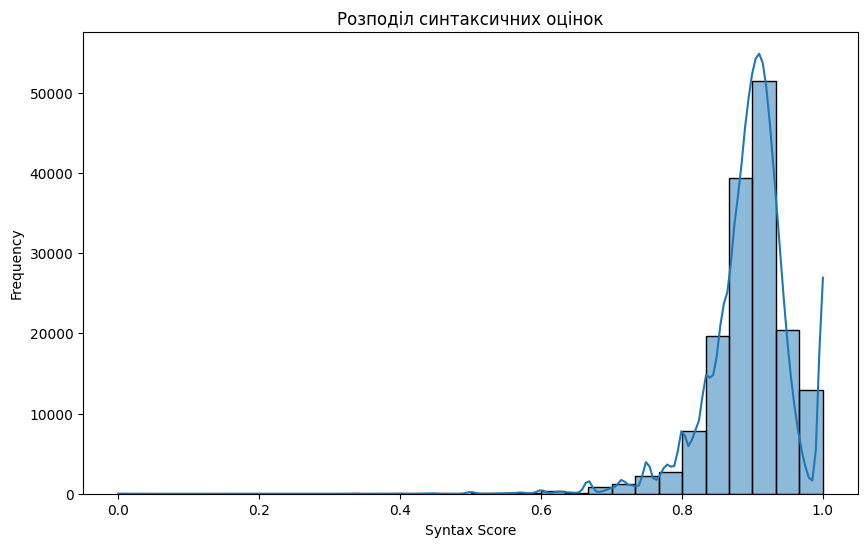

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Візуалізація розподілу синтаксичних оцінок
plt.figure(figsize=(10, 6))
sns.histplot(train_data['syntax_score'], kde=True, bins=30)
plt.title('Розподіл синтаксичних оцінок')
plt.xlabel('Syntax Score')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Фільтрація коментарів на основі граматичних оцінок
df_cleaned = train_data[train_data['syntax_score'] >= 0.7]

df_cleaned.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comment,syntax_score
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...,0.938776
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww! he matches this background colour i'm s...,0.782609
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"hey man, i'm really not trying to edit war. it...",0.916667
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can't make any real suggestions on impr...,0.956897
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"you, sir, are my hero. any chance you remember...",0.777778


In [12]:
# Функція для видалення повторюваних слів
def remove_repeated_words(text):
    # Розбиваємо текст на слова
    words = text.split()
    # Створюємо словник для збереження унікальних слів
    seen = set()
    result = []
    
    for word in words:
        # Додаємо слово, якщо воно ще не зустрічалось
        if word not in seen:
            seen.add(word)
            result.append(word)
    
    # З'єднуємо слова назад у текст
    return ' '.join(result)

# Застосування до стовпця з коментарями
df_cleaned['cleaned_comment'] = df_cleaned['cleaned_comment'].apply(remove_repeated_words)

/tmp/ipykernel_74823/500219704.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned_comment'] = df_cleaned['cleaned_comment'].apply(remove_repeated_words)


In [13]:
from transformers import BertTokenizer

# Завантажуємо токенізатор BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Підрахунок кількості токенів у кожному очищеному коментарі
df_cleaned['token_count'] = df_cleaned['cleaned_comment'].apply(lambda x: len(tokenizer.tokenize(x)))

# Сортування датасету за кількістю токенів у спадаючому порядку
df_sorted_by_tokens = df_cleaned.sort_values(by='token_count', ascending=False)

/home/aleksander/.cache/pypoetry/virtualenvs/goit-python-ds-project-7wSOhx7v-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
/tmp/ipykernel_74823/2712517131.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['token_count'] = df_cleaned['cleaned_comment'].apply(lambda x: len(tokenizer.tokenize(x)))


In [14]:
# Виведення 20 коментарів з найбільшою кількістю токенів
top_20_comments = df_sorted_by_tokens[['cleaned_comment', 'token_count']].head(20)

# Виведення результату
print(top_20_comments)

                                          cleaned_comment  token_count
73403   you are a twat twat'twat'twat'twat'twat'twat't...         1417
150478  mercedesbenz o530 citaro batch 1 lifespan expi...         1349
80819   references i don't like deleting other people'...         1040
138179  exactly. alot of this information you cannot f...          932
108277  , admits that, if less unjust and violent meas...          859
73294   david irving v penguin books and deborah lipst...          825
18100   you swine. vulgar little maggot. worthless bag...          815
48976   english translation of page tab kose mhal'n to...          811
18698   added. you arenwo on my yahoo list. lets be ci...          809
147587  neautrality and balance. article is strong ant...          802
119788  the arbitration comity has absolutly nothing t...          791
134370  thiru muruga kirupanandha variyar, popularly k...          752
139132  on musical influences section archuleta's moth...          750
128827

In [15]:
cleaned_data = train_data.copy()

# Зберігаємо очищений датасет у CSV файл
output_path = 'cleaned_toxic_comments.csv'

# Записуємо очищені коментарі у файл
df_cleaned[['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 
             'threat', 'insult', 'identity_hate', 'cleaned_comment']].to_csv(output_path, index=False)

print(f"Очищений датасет збережено у файл: {output_path}")

Очищений датасет збережено у файл: cleaned_toxic_comments.csv
